In [1]:
# Connect to Google Drive (optional but recommended for saving models)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics kaggle torch torchvision opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [3]:
# Set up Kaggle API (upload your kaggle.json first)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d gauravduttakiit/agricultural-pests-dataset
!unzip agricultural-pests-dataset.zip -d pest_data

Streaming output truncated to the last 5000 lines.
  inflating: pest_data/test/earwig/earwig (307).jpg  
  inflating: pest_data/test/earwig/earwig (308).jpg  
  inflating: pest_data/test/earwig/earwig (309).jpg  
  inflating: pest_data/test/earwig/earwig (31).jpg  
  inflating: pest_data/test/earwig/earwig (315).jpg  
  inflating: pest_data/test/earwig/earwig (33).jpg  
  inflating: pest_data/test/earwig/earwig (331).jpg  
  inflating: pest_data/test/earwig/earwig (334).jpg  
  inflating: pest_data/test/earwig/earwig (338).jpg  
  inflating: pest_data/test/earwig/earwig (34).jpg  
  inflating: pest_data/test/earwig/earwig (343).jpg  
  inflating: pest_data/test/earwig/earwig (348).jpg  
  inflating: pest_data/test/earwig/earwig (35).jpg  
  inflating: pest_data/test/earwig/earwig (353).jpg  
  inflating: pest_data/test/earwig/earwig (358).jpg  
  inflating: pest_data/test/earwig/earwig (367).jpg  
  inflating: pest_data/test/earwig/earwig (368).jpg  
  inflating: pest_data/test/earwig/

In [4]:
import pandas as pd
import os
import shutil
import yaml
from sklearn.model_selection import train_test_split

# Create YOLO classification directory structure
dataset_path = 'pest_data_yolo_classification'
os.makedirs(dataset_path, exist_ok=True)

# Create train and val directories with class subfolders
for split in ['train', 'val', 'test']:
    os.makedirs(f'{dataset_path}/{split}', exist_ok=True)

# Read the CSV files
train_df = pd.read_csv('pest_data/train.csv')
test_df = pd.read_csv('pest_data/test.csv')

# Function to extract class name and filename from full path
def extract_class_and_filename(full_path):
    parts = full_path.split('/')
    return parts[-2], parts[-1]  # (class_name, filename)

# Update the dataframes
train_df['label'], train_df['filename'] = zip(*train_df['filename'].apply(extract_class_and_filename))
test_df['label'], test_df['filename'] = zip(*test_df['filename'].apply(extract_class_and_filename))

# Get class names and create mapping
class_names = sorted(train_df['label'].unique())

# Split train into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

# Function to prepare classification dataset (using folder structure)
def prepare_classification_dataset(df, source_subfolder, target_folder):
    images_copied = 0
    for class_name in class_names:
        os.makedirs(os.path.join(target_folder, class_name), exist_ok=True)

    for _, row in df.iterrows():
        img_path = os.path.join('pest_data', source_subfolder, row['label'], row['filename'])
        target_path = os.path.join(target_folder, row['label'], row['filename'])

        if os.path.exists(img_path):
            try:
                shutil.copy(img_path, target_path)
                images_copied += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        else:
            print(f"Warning: Image not found at {img_path}")

    print(f"Copied {images_copied} images to {target_folder}")

# Prepare datasets
print("\nPreparing training set...")
prepare_classification_dataset(train_df, 'train', f'{dataset_path}/train')

print("\nPreparing validation set...")
prepare_classification_dataset(val_df, 'train', f'{dataset_path}/val')

print("\nPreparing test set...")
prepare_classification_dataset(test_df, 'test', f'{dataset_path}/test')

# Verify dataset
print("\nVerifying dataset:")
for split in ['train', 'val', 'test']:
    split_path = f'{dataset_path}/{split}'
    if os.path.exists(split_path):
        num_images = 0
        for class_name in class_names:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                num_images += len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"{split.capitalize()}: {num_images} images")

# Create proper YAML configuration for classification
yaml_content = {
    'path': os.path.abspath(dataset_path),
    'train': 'train',
    'val': 'val',
    'test': 'test',
    'nc': len(class_names),
    'names': class_names
}

with open('/content/pest_data_yolo_classification/pest_classification_dataset.yaml', 'w') as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print("\nYAML configuration:")
print(yaml.dump(yaml_content, default_flow_style=False, sort_keys=False))
print("\nDataset structure created successfully for YOLO classification!")


Preparing training set...
Copied 3516 images to pest_data_yolo_classification/train

Preparing validation set...
Copied 879 images to pest_data_yolo_classification/val

Preparing test set...
Copied 1099 images to pest_data_yolo_classification/test

Verifying dataset:
Train: 3516 images
Val: 879 images
Test: 1099 images

YAML configuration:
path: /content/pest_data_yolo_classification
train: train
val: val
test: test
nc: 12
names:
- ants
- bees
- beetle
- catterpillar
- earthworms
- earwig
- grasshopper
- moth
- slug
- snail
- wasp
- weevil


Dataset structure created successfully for YOLO classification!


In [26]:
# Step 5: Train YOLOv11 classification model
from ultralytics import YOLO
import os

# Verify dataset structure
dataset_yaml = '/content/pest_data_yolo_classification/'
if not os.path.exists(dataset_yaml):
    raise FileNotFoundError(f"Dataset YAML file not found at {dataset_yaml}")

# Check if the dataset contains images
def verify_dataset_split(split_path):
    if not os.path.exists(split_path):
        return False
    class_dirs = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    if not class_dirs:
        return False
    for class_dir in class_dirs:
        class_path = os.path.join(split_path, class_dir)
        if not any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in os.listdir(class_path)):
            return False
    return True

for split in ['train', 'val']:
    split_path = os.path.join('/content/pest_data_yolo_classification', split)
    if not verify_dataset_split(split_path):
        raise ValueError(f"Dataset split {split} is empty or improperly structured at {split_path}")

# Load YOLOv11 classification model
try:
    # Load YOLOv11 classification model (automatically downloads if not found)
    model = YOLO('yolo11s-cls.pt')  # Nano version for faster training
    print("YOLOv11 model loaded successfully. Architecture summary:")
    model.info()  # Print model summary
except Exception as e:
    raise RuntimeError(f"Failed to load YOLOv11 model: {e}")

# Training configuration
try:
    results = model.train(
        data=dataset_yaml,
        epochs=25,
        imgsz=224,
        task='classify',
        batch=64,
        patience=5,
        device='0',
        workers=4,
        optimizer='AdamW',
        lr0=0.001,
        weight_decay=0.0005,
        warmup_epochs=3,
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        flipud=0.5,
        fliplr=0.5,
        mosaic=0.0,
        degrees=10.0,
        translate=0.1,
        scale=0.5,
        shear=2.0,
        perspective=0.0001,
        seed=42,
        name='yolo11s_pest_classification',  # Changed to reflect YOLOv11
        exist_ok=True
    )

    print("\nTraining completed successfully!")
    print(f"Best model saved to: {results.save_dir}")
    print(f"Top-1 Accuracy: {results.metrics.top1:.2f}%")
    print(f"Top-5 Accuracy: {results.metrics.top5:.2f}%")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    print("\nTroubleshooting steps:")
    print("1. Verify the dataset YAML file exists at the correct path")
    print("2. Check that images exist in train/ and val/ directories with proper class subfolders")
    print("3. Ensure images are valid (try opening some manually)")
    print("4. Try reducing batch size if you get CUDA memory errors")
    print("5. Try running with device='cpu' if GPU is not available")
    print("6. Check disk space (training creates many checkpoint files)")



YOLOv11 model loaded successfully. Architecture summary:
YOLO11s-cls summary: 86 layers, 6,724,008 parameters, 0 gradients, 13.2 GFLOPs
New https://pypi.org/project/ultralytics/8.3.154 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/pest_data_yolo_classification/, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300,

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1226.4±283.7 MB/s, size: 39.8 KB)


train: Scanning /content/pest_data_yolo_classification/train... 3516 images, 0 corrupt: 100%|██████████| 3516/3516 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 454.4±263.0 MB/s, size: 22.5 KB)


val: Scanning /content/pest_data_yolo_classification/val... 879 images, 0 corrupt: 100%|██████████| 879/879 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/yolo11s_pest_classification
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all       0.79      0.976



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all      0.717      0.953



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

                   all      0.741      0.959



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all       0.73      0.961



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all      0.777      0.967



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all      0.803      0.984



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all      0.826      0.986



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all      0.843      0.986



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all      0.846      0.986



      Epoch    GPU_mem       loss  Instances       Size


      10/25      1.92G      0.425         60        224: 100%|██████████| 55/55 [00:18<00:00,  3.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all       0.84      0.981



      Epoch    GPU_mem       loss  Instances       Size


      11/25      1.92G     0.4047         60        224: 100%|██████████| 55/55 [00:19<00:00,  2.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all      0.833      0.985



      Epoch    GPU_mem       loss  Instances       Size


      12/25      1.92G     0.3845         60        224: 100%|██████████| 55/55 [00:18<00:00,  3.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all      0.851      0.983



      Epoch    GPU_mem       loss  Instances       Size


      13/25      1.92G     0.3456         60        224: 100%|██████████| 55/55 [00:19<00:00,  2.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all       0.84       0.99



      Epoch    GPU_mem       loss  Instances       Size


      14/25      1.92G     0.3189         60        224: 100%|██████████| 55/55 [00:18<00:00,  3.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all      0.887      0.987



      Epoch    GPU_mem       loss  Instances       Size


      15/25      1.92G     0.2778         60        224: 100%|██████████| 55/55 [00:19<00:00,  2.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all      0.881       0.99



      Epoch    GPU_mem       loss  Instances       Size


      16/25      1.92G     0.2506         64        224:  33%|███▎      | 18/55 [00:07<00:18,  2.00it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1c2fb00e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb1c2fb00e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shu

                   all      0.885      0.991



      Epoch    GPU_mem       loss  Instances       Size


      17/25      1.92G     0.2307         60        224: 100%|██████████| 55/55 [00:19<00:00,  2.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all      0.894      0.987



      Epoch    GPU_mem       loss  Instances       Size


      18/25      1.92G      0.208         60        224: 100%|██████████| 55/55 [00:18<00:00,  2.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        0.9       0.99



      Epoch    GPU_mem       loss  Instances       Size


      19/25      1.92G     0.1996         60        224: 100%|██████████| 55/55 [00:19<00:00,  2.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all      0.898       0.99



      Epoch    GPU_mem       loss  Instances       Size


      20/25      1.92G     0.1751         60        224: 100%|██████████| 55/55 [00:18<00:00,  2.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all      0.874      0.987



      Epoch    GPU_mem       loss  Instances       Size


      21/25      1.92G     0.1564         60        224: 100%|██████████| 55/55 [00:19<00:00,  2.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all      0.903      0.987



      Epoch    GPU_mem       loss  Instances       Size


      22/25      1.92G     0.1567         60        224: 100%|██████████| 55/55 [00:18<00:00,  3.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        0.9      0.986



      Epoch    GPU_mem       loss  Instances       Size


      23/25      1.92G     0.1277         60        224: 100%|██████████| 55/55 [00:19<00:00,  2.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all      0.902      0.986



      Epoch    GPU_mem       loss  Instances       Size


      24/25      1.92G     0.1381         60        224: 100%|██████████| 55/55 [00:18<00:00,  3.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all      0.896      0.985



      Epoch    GPU_mem       loss  Instances       Size


      25/25      1.92G     0.1121         60        224: 100%|██████████| 55/55 [00:19<00:00,  2.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all      0.904      0.987



25 epochs completed in 0.153 hours.
Optimizer stripped from runs/classify/yolo11s_pest_classification/weights/last.pt, 11.1MB
Optimizer stripped from runs/classify/yolo11s_pest_classification/weights/best.pt, 11.1MB

Validating runs/classify/yolo11s_pest_classification/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-cls summary (fused): 47 layers, 5,449,500 parameters, 0 gradients, 12.0 GFLOPs
train: /content/pest_data_yolo_classification/train... found 3516 images in 12 classes ✅ 
val: /content/pest_data_yolo_classification/val... found 879 images in 12 classes ✅ 
test: /content/pest_data_yolo_classification/test... found 1099 images in 12 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


                   all      0.903      0.987
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolo11s_pest_classification

Training completed successfully!
Best model saved to: runs/classify/yolo11s_pest_classification

Training failed with error: 'ClassifyMetrics' object has no attribute 'metrics'. See valid attributes below.

    Class for computing classification metrics including top-1 and top-5 accuracy.

    Attributes:
        top1 (float): The top-1 accuracy.
        top5 (float): The top-5 accuracy.
        speed (dict): A dictionary containing the time taken for each step in the pipeline.
        task (str): The task type, set to 'classify'.
    

Troubleshooting steps:
1. Verify the dataset YAML file exists at the correct path
2. Check that images exist in train/ and val/ directories with proper class subfolders
3. Ensure images are valid (try opening some manually)
4. Try reducing batch size if you get CUDA mem

In [27]:
# Check if the YAML file exists
print(f"YAML file exists: {os.path.exists('/content/pest_data_yolo_classification/pest_classification_dataset.yaml')}")

# Print the contents of the YAML file
with open('/content/pest_data_yolo_classification/pest_classification_dataset.yaml', 'r') as f:
    print("\nYAML file contents:")
    print(f.read())

YAML file exists: True

YAML file contents:
path: /content/pest_data_yolo_classification/
train: train
val: val
test: test
nc: 12
names: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']




Loaded model from runs/classify/yolo11s_pest_classification/weights/best.pt

Evaluating on validation set...
Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-cls summary (fused): 47 layers, 5,449,500 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1048.1±410.7 MB/s, size: 22.5 KB)


val: Scanning /content/pest_data_yolo_classification/val... 879 images, 0 corrupt: 100%|██████████| 879/879 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 28/28 [00:02<00:00, 10.35it/s]


                   all      0.904      0.987
Speed: 0.3ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val2
Validation accuracy: 0.90%
Validation top5 accuracy: 0.99%

Evaluating on test set...

Test Accuracy: 89.44%

Classification Report:
              precision    recall  f1-score   support

        ants      0.924     0.980     0.951        99
        bees      0.919     0.958     0.938        95
      beetle      0.797     0.647     0.714        85
catterpillar      0.892     0.790     0.838       105
  earthworms      0.882     0.870     0.876        77
      earwig      0.782     0.803     0.792        76
 grasshopper      0.810     0.895     0.850        95
        moth      0.950     0.950     0.950       100
        slug      0.851     0.840     0.846        75
       snail      0.969     0.989     0.979        95
        wasp      0.945     0.981     0.963       106
      weevil      0.946     0.967     0.957        91



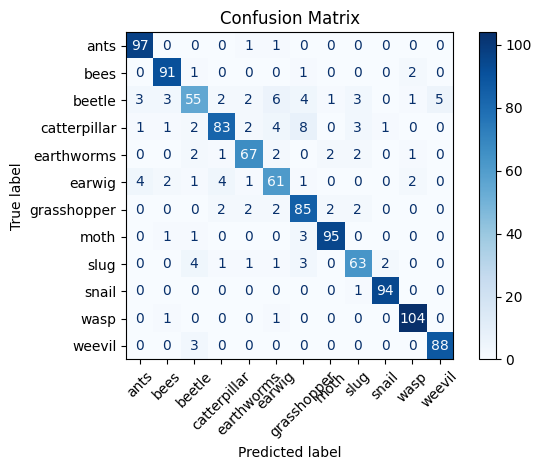

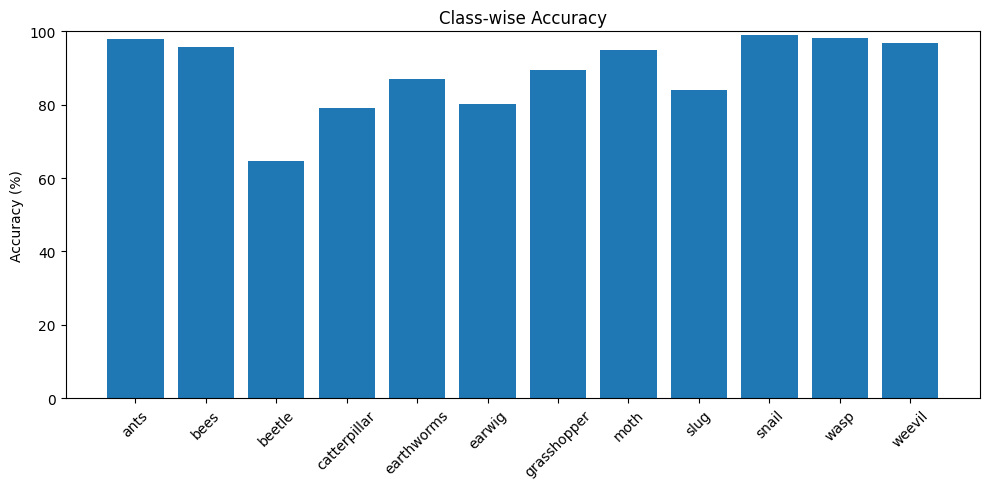


Evaluation complete. Metrics saved to evaluation_metrics.yaml
Visualizations saved to confusion_matrix.png and class_accuracy.png


In [28]:
# Step 6: Evaluate YOLOv8 Classification Model
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import yaml

# Configuration
model_path = os.path.join('runs', 'classify', 'yolo11s_pest_classification', 'weights', 'best.pt')
dataset_yaml = '/content/pest_data_yolo_classification/pest_classification_dataset.yaml'
test_dir = '/content/pest_data_yolo_classification/test'  # Path to test set
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32

def load_class_names(yaml_path):
    """Load class names from YAML file"""
    with open(yaml_path) as f:
        data = yaml.safe_load(f)
    return data['names']

def evaluate_model(model_path, dataset_yaml, test_dir, device='cuda', batch_size=32):
    """Evaluate trained classification model"""
    # Load model
    try:
        model = YOLO(model_path)
        print(f"Loaded model from {model_path}")
    except Exception as e:
        raise RuntimeError(f"Failed to load model: {e}")

    # Load class names
    class_names = load_class_names(dataset_yaml)
    num_classes = len(class_names)

    # Validation evaluation (from YAML)
    print("\nEvaluating on validation set...")
    val_metrics = model.val(data=dataset_yaml, batch=batch_size, device=device)
    print(f"Validation accuracy: {val_metrics.top1:.2f}%")
    print(f"Validation top5 accuracy: {val_metrics.top5:.2f}%")

    # Test evaluation (if test directory exists)
    if os.path.exists(test_dir):
        print("\nEvaluating on test set...")
        test_results = []
        true_labels = []
        pred_labels = []

        # Process each class folder
        for class_idx, class_name in enumerate(class_names):
            class_path = os.path.join(test_dir, class_name)
            if not os.path.exists(class_path):
                continue

            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)
                    results = model(img_path, verbose=False)  # Predict

                    # Get top prediction
                    top_pred = results[0].probs.top1
                    test_results.append(top_pred == class_idx)
                    true_labels.append(class_idx)
                    pred_labels.append(top_pred)

        # Calculate metrics
        accuracy = np.mean(test_results) * 100
        print(f"\nTest Accuracy: {accuracy:.2f}%")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, pred_labels, target_names=class_names, digits=3))

        # Confusion matrix
        cm = confusion_matrix(true_labels, pred_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()

        # Class-wise accuracy
        class_acc = cm.diagonal() / cm.sum(axis=1) * 100
        plt.figure(figsize=(10, 5))
        plt.bar(class_names, class_acc)
        plt.title('Class-wise Accuracy')
        plt.ylabel('Accuracy (%)')
        plt.ylim(0, 100)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('class_accuracy.png')
        plt.show()

        return {
            'val_accuracy': val_metrics.top1,
            'val_top5': val_metrics.top5,
            'test_accuracy': accuracy,
            'confusion_matrix': cm,
            'class_accuracies': dict(zip(class_names, class_acc))
        }
    else:
        print("\nTest directory not found, skipping test evaluation")
        return {
            'val_accuracy': val_metrics.top1,
            'val_top5': val_metrics.top5
        }

# Run evaluation
if __name__ == "__main__":
    # Check if model exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}. Train the model first.")

    # Run evaluation
    metrics = evaluate_model(
        model_path=model_path,
        dataset_yaml=dataset_yaml,
        test_dir=test_dir,
        device=device,
        batch_size=batch_size
    )

    # Save metrics
    with open('evaluation_metrics.yaml', 'w') as f:
        yaml.dump(metrics, f)

    print("\nEvaluation complete. Metrics saved to evaluation_metrics.yaml")
    print("Visualizations saved to confusion_matrix.png and class_accuracy.png")